In [1]:
import cv2 as cv
import mediapipe as mp
import numpy as np

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [3]:
# For video input:
def human_pose_estimation(input_video_path, output_video_path):
  capture = cv.VideoCapture(input_video_path)
  with mp_pose.Pose(
      model_complexity=2,
      min_tracking_confidence=0.5) as pose:
    frame_size  = (int(capture.get(cv.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv.CAP_PROP_FRAME_HEIGHT)))
    frame_rate = capture.get(cv.CAP_PROP_FPS)
    fourcc = cv.VideoWriter_fourcc(*"MJPG")
    output = cv.VideoWriter(output_video_path, fourcc, frame_rate, frame_size)
    while True:
      ret, frame = capture.read()
      if frame is None:
        break
      # To improve performance, optionally mark the frame as not writeable to
      # pass by reference.
      frame.flags.writeable = False
      frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
      results = pose.process(frame)

      # Draw the pose annotation on the frame.
      frame.flags.writeable = True
      frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
      mp_drawing.draw_landmarks(
          frame,
          results.pose_landmarks,
          mp_pose.POSE_CONNECTIONS,
          landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
      # Flip the frame horizontally for a selfie-view display.
      output.write(frame)
  capture.release()
  output.release()

In [4]:
for video_num in range(0, 10):
    input_video_path = f"./imp/videos/training_{video_num}.mov"
    output_video_path = f"./imp/human_pose_estimation/training_{video_num}.avi"
    human_pose_estimation(input_video_path, output_video_path)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Nose coordinates: (920.5815113782883, 434.34062218666077)


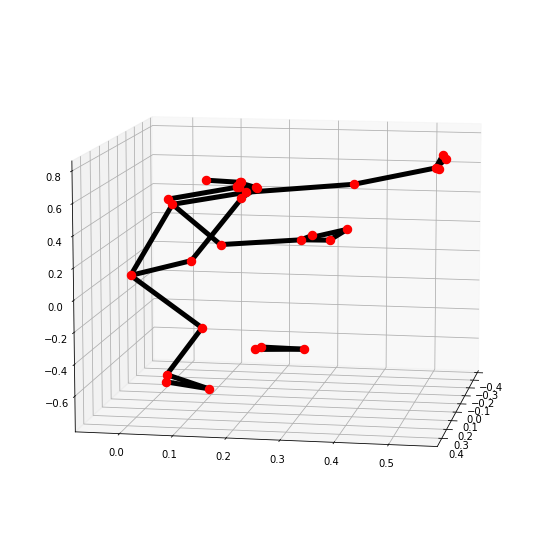

In [9]:
# For static images:
IMAGE_FILES = ['./test.jpeg']
BG_COLOR = (192, 192, 192) # gray
with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))

    if not results.pose_landmarks:
      continue
    print(
        f'Nose coordinates: ('
        f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
        f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
    )

    annotated_image = image.copy()
    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)
    # Draw pose landmarks on the image.
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    cv.imwrite('./annotated_image' + str(idx) + '.png', annotated_image)
    # Plot pose world landmarks.
    mp_drawing.plot_landmarks(
        results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)